In [7]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn')
sns.set_palette("husl")

In [9]:
df = pd.read_csv('output.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset Shape: (1133967, 24)

Columns: ['PWSID', 'PWSName', 'Size', 'FacilityID', 'FacilityName', 'FacilityWaterType', 'SamplePointID', 'SamplePointName', 'SamplePointType', 'AssociatedFacilityID', 'AssociatedSamplePointID', 'CollectionDate', 'SampleID', 'Contaminant', 'MRL', 'Units', 'MethodID', 'AnalyticalResultsSign', 'AnalyticalResultValue', 'SampleEventCode', 'MonitoringRequirement', 'Region', 'State', 'UCMR1SampleType']

First few rows:


,PWSID,PWSName,Size,FacilityID,FacilityName,FacilityWaterType,SamplePointID,SamplePointName,SamplePointType,AssociatedFacilityID,...,MRL,Units,MethodID,AnalyticalResultsSign,AnalyticalResultValue,SampleEventCode,MonitoringRequirement,Region,State,UCMR1SampleType
0,010106001,Mashantucket Pequot Water System,L,00006,MPTN WTP,GU,TP1,Entry point to Dist. System,EP,NaN,...,0.003,µg/L,EPA 533,<,NaN,SE1,AM,1,01,NaN
1,010106001,Mashantucket Pequot Water System,L,00006,MPTN WTP,GU,TP1,Entry point to Dist. System,EP,NaN,...,0.003,µg/L,EPA 533,<,NaN,SE1,AM,1,01,NaN
2,010106001,Mashantucket Pequot Water System,L,00006,MPTN WTP,GU,TP1,Entry point to Dist. System,EP,NaN,...,0.003,µg/L,EPA 533,<,NaN,SE1,AM,1,01,NaN
3,010106001,Mashantucket Pequot Water System,L,00006,MPTN WTP,GU,TP1,Entry point to Dist. System,EP,NaN,...,0.003,µg/L,EPA 533,=,0.0036,SE1,AM,1,01,NaN
4,010106001,Mashantucket Pequot Water System,L,00006,MPTN WTP,GU,TP1,Entry point to Dist. System,EP,NaN,...,0.005,µg/L,EPA 537.1,<,NaN,SE1,AM,1,01,NaN


In [10]:
# Cell 3: Initial Data Processing
# Convert date
df['CollectionDate'] = pd.to_datetime(df['CollectionDate'])

# Handle results below MRL
df['Value'] = np.where(df['AnalyticalResultsSign'] == '<', 
                      df['MRL'] / 2,  # Use half the MRL for non-detects
                      df['AnalyticalResultValue'])

# Create geographic grouping
df['RegionState'] = df['Region'].astype(str) + '_' + df['State']

# Display summary statistics
print("Data Summary:")
print(f"Number of unique water systems: {df['PWSID'].nunique()}")
print(f"Date range: {df['CollectionDate'].min()} to {df['CollectionDate'].max()}")
print(f"Number of Regions: {df['Region'].nunique()}")
print(f"Water Types: {df['FacilityWaterType'].unique()}")

# Display summary of PFAS measurements
print("\nPFAS Measurements Summary:")
print(df['Value'].describe())

Data Summary:
Number of unique water systems: 7237
Date range: 2023-01-03 00:00:00 to 2024-09-30 00:00:00
Number of Regions: 10
Water Types: ['GU' 'SW' 'GW' 'MX']

PFAS Measurements Summary:
count    1.133967e+06
mean     4.452188e-01
std      5.571711e+00
min      1.000000e-03
25%      1.500000e-03
50%      2.000000e-03
75%      2.500000e-03
max      9.600000e+02
Name: Value, dtype: float64


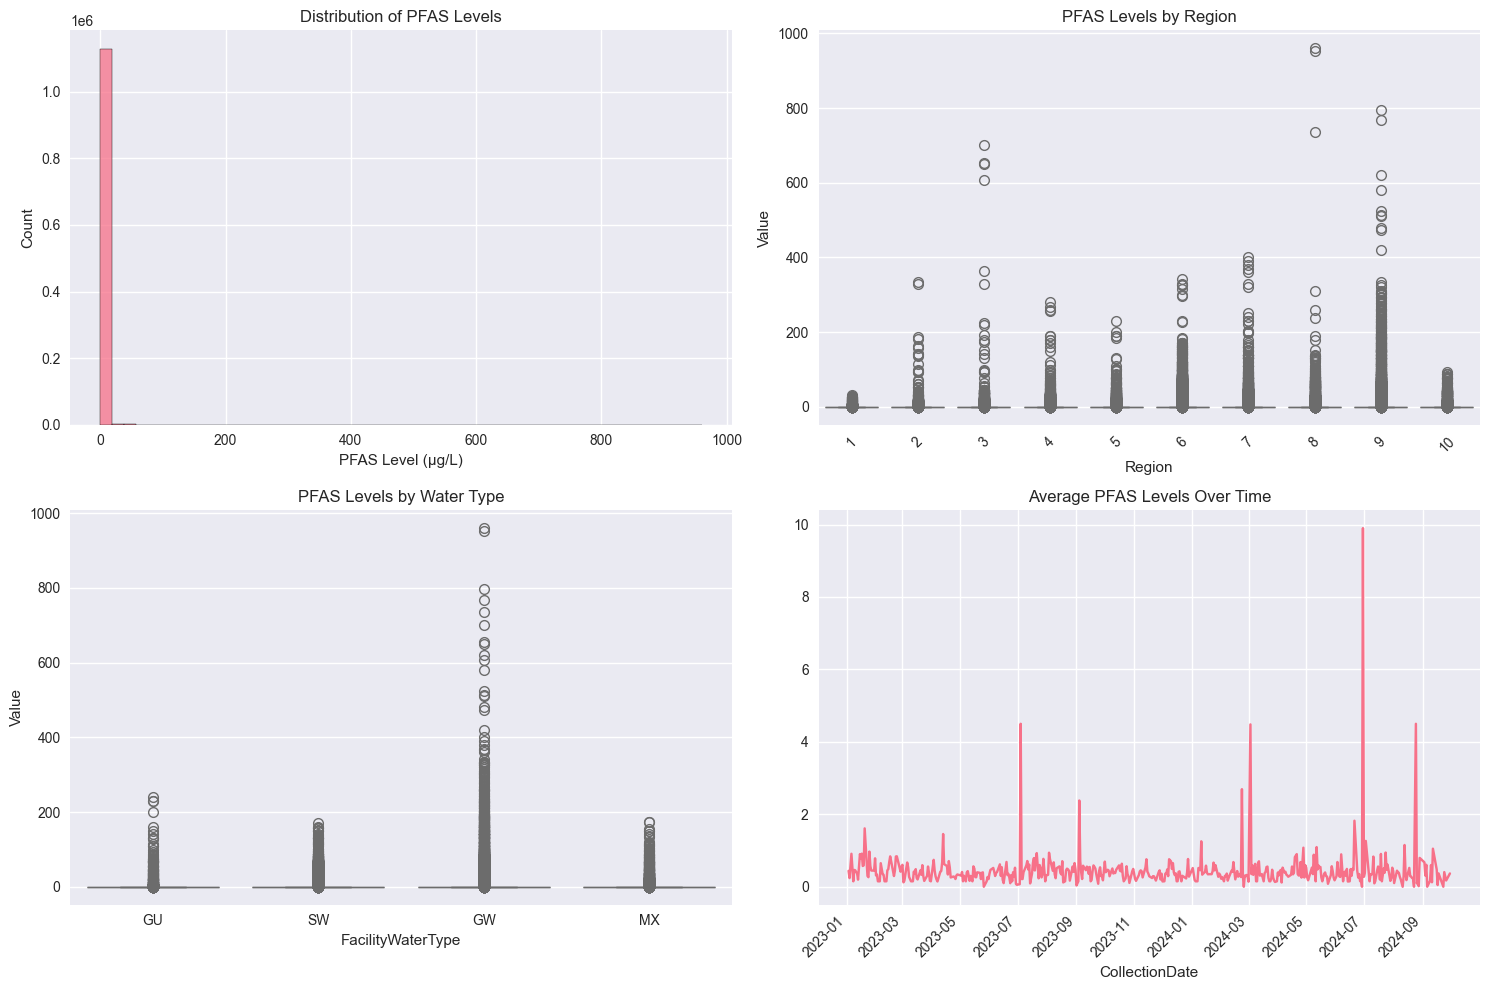

In [11]:
# Cell 4: Exploratory Data Analysis
plt.figure(figsize=(15, 10))

# Plot 1: PFAS Levels Distribution
plt.subplot(2, 2, 1)
sns.histplot(df['Value'], bins=50)
plt.title('Distribution of PFAS Levels')
plt.xlabel('PFAS Level (μg/L)')

# Plot 2: PFAS Levels by Region
plt.subplot(2, 2, 2)
sns.boxplot(x='Region', y='Value', data=df)
plt.title('PFAS Levels by Region')
plt.xticks(rotation=45)

# Plot 3: PFAS Levels by Water Type
plt.subplot(2, 2, 3)
sns.boxplot(x='FacilityWaterType', y='Value', data=df)
plt.title('PFAS Levels by Water Type')

# Plot 4: PFAS Levels Over Time
plt.subplot(2, 2, 4)
df.groupby('CollectionDate')['Value'].mean().plot()
plt.title('Average PFAS Levels Over Time')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [12]:
# Cell 5: Feature Engineering
# Create time-based features
df['Month'] = df['CollectionDate'].dt.month
df['Year'] = df['CollectionDate'].dt.year

# Create water system size indicator
df['IsLarge'] = (df['Size'] == 'L').astype(int)

# Create water type indicators
water_type_dummies = pd.get_dummies(df['FacilityWaterType'], prefix='WaterType')
df = pd.concat([df, water_type_dummies], axis=1)

# Create regional indicators
region_dummies = pd.get_dummies(df['Region'], prefix='Region')
df = pd.concat([df, region_dummies], axis=1)

# Display the new features
print("Features created. New columns:")
print(df.columns[-15:].tolist())  # Show last 15 columns

Features created. New columns:
['IsLarge', 'WaterType_GU', 'WaterType_GW', 'WaterType_MX', 'WaterType_SW', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 'Region_10']


In [13]:
# Cell 6: Data Aggregation
# Group data by date and region for analysis
def aggregate_data(df):
    grouped = df.groupby(['CollectionDate', 'Region']).agg({
        'Value': ['mean', 'median', 'std', 'count'],
        'IsLarge': 'mean',
        'WaterType_GW': 'mean',
        'WaterType_SW': 'mean',
        'WaterType_GU': 'mean',
        'WaterType_MX': 'mean'
    }).reset_index()
    
    grouped.columns = ['CollectionDate', 'Region', 'Value_mean', 'Value_median', 
                      'Value_std', 'Sample_count', 'Large_system_ratio',
                      'GW_ratio', 'SW_ratio', 'GU_ratio', 'MX_ratio']
    return grouped

# Aggregate the data
df_agg = aggregate_data(df)
print("Aggregated data shape:", df_agg.shape)
print("\nFirst few rows of aggregated data:")
df_agg.head()

Aggregated data shape: (3395, 11)

First few rows of aggregated data:


,CollectionDate,Region,Value_mean,Value_median,Value_std,Sample_count,Large_system_ratio,GW_ratio,SW_ratio,GU_ratio,MX_ratio
0,2023-01-03,2,0.152202,0.002,0.810753,120,1.0,1.0,0.000000,0.0,0.000000
1,2023-01-03,4,0.152183,0.002,0.810756,120,1.0,1.0,0.000000,0.0,0.000000
2,2023-01-03,5,0.103331,0.002,0.670400,89,1.0,0.0,0.662921,0.0,0.337079
3,2023-01-03,6,0.152183,0.002,0.821173,30,0.0,0.0,1.000000,0.0,0.000000
4,2023-01-03,8,0.152183,0.002,0.821173,30,1.0,0.0,1.000000,0.0,0.000000


In [15]:
# Cell 6: Data Aggregation with Time Features
def aggregate_data(df):
    # First extract date components
    df['Month'] = df['CollectionDate'].dt.month
    df['Year'] = df['CollectionDate'].dt.year
    
    # Group data by date, region, and contaminant
    grouped = df.groupby(['CollectionDate', 'Region', 'Contaminant']).agg({
        'Value': ['mean', 'median', 'std', 'count'],
        'IsLarge': 'mean',
        'WaterType_GW': 'mean',
        'WaterType_SW': 'mean',
        'WaterType_GU': 'mean',
        'WaterType_MX': 'mean',
        'Month': 'first',  # Keep the month
        'Year': 'first'    # Keep the year
    }).reset_index()
    
    # Flatten column names
    grouped.columns = ['CollectionDate', 'Region', 'Contaminant', 
                      'Value_mean', 'Value_median', 'Value_std', 'Sample_count',
                      'Large_system_ratio', 'GW_ratio', 'SW_ratio', 'GU_ratio', 
                      'MX_ratio', 'Month', 'Year']
    
    return grouped

# Aggregate the data
df_agg = aggregate_data(df)
print("Aggregated data shape:", df_agg.shape)
print("\nUnique contaminants:", df_agg['Contaminant'].unique())
print("\nFirst few rows of aggregated data:")
df_agg.head()

Aggregated data shape: (98093, 14)

Unique contaminants: ['11Cl-PF3OUdS' '4:2 FTS' '6:2 FTS' '8:2 FTS' '9Cl-PF3ONS' 'ADONA'
 'HFPO-DA' 'NEtFOSAA' 'NFDHA' 'NMeFOSAA' 'PFBA' 'PFBS' 'PFDA' 'PFDoA'
 'PFEESA' 'PFHpA' 'PFHpS' 'PFHxA' 'PFHxS' 'PFMBA' 'PFMPA' 'PFNA' 'PFOA'
 'PFOS' 'PFPeA' 'PFPeS' 'PFTA' 'PFTrDA' 'PFUnA' 'lithium']

First few rows of aggregated data:


,CollectionDate,Region,Contaminant,Value_mean,Value_median,Value_std,Sample_count,Large_system_ratio,GW_ratio,SW_ratio,GU_ratio,MX_ratio,Month,Year
0,2023-01-03,2,11Cl-PF3OUdS,0.0025,0.0025,0.0,4,1.0,1.0,0.0,0.0,0.0,1,2023
1,2023-01-03,2,4:2 FTS,0.0015,0.0015,0.0,4,1.0,1.0,0.0,0.0,0.0,1,2023
2,2023-01-03,2,6:2 FTS,0.0025,0.0025,0.0,4,1.0,1.0,0.0,0.0,0.0,1,2023
3,2023-01-03,2,8:2 FTS,0.0025,0.0025,0.0,4,1.0,1.0,0.0,0.0,0.0,1,2023
4,2023-01-03,2,9Cl-PF3ONS,0.0010,0.0010,0.0,4,1.0,1.0,0.0,0.0,0.0,1,2023


PFAS Compounds Summary:
              Detection_Rate  Sample_Count     Mean  Median      Std
Contaminant                                                         
lithium               0.2792         38490  13.0485  4.5000  27.3896
PFPeA                 0.1062         37688   0.0023  0.0015   0.0062
PFHxA                 0.0932         37696   0.0020  0.0015   0.0026
PFBS                  0.0878         37699   0.0020  0.0015   0.0037
PFBA                  0.0830         37677   0.0033  0.0025   0.0098
PFOS                  0.0688         37698   0.0025  0.0020   0.0034
PFOA                  0.0649         37699   0.0024  0.0020   0.0026
PFHxS                 0.0540         37697   0.0018  0.0015   0.0024
PFHpA                 0.0234         37704   0.0016  0.0015   0.0009
6:2 FTS               0.0045         37691   0.0026  0.0025   0.0066
PFNA                  0.0023         37705   0.0020  0.0020   0.0007
PFPeS                 0.0019         37701   0.0020  0.0020   0.0003
HFPO-DA   

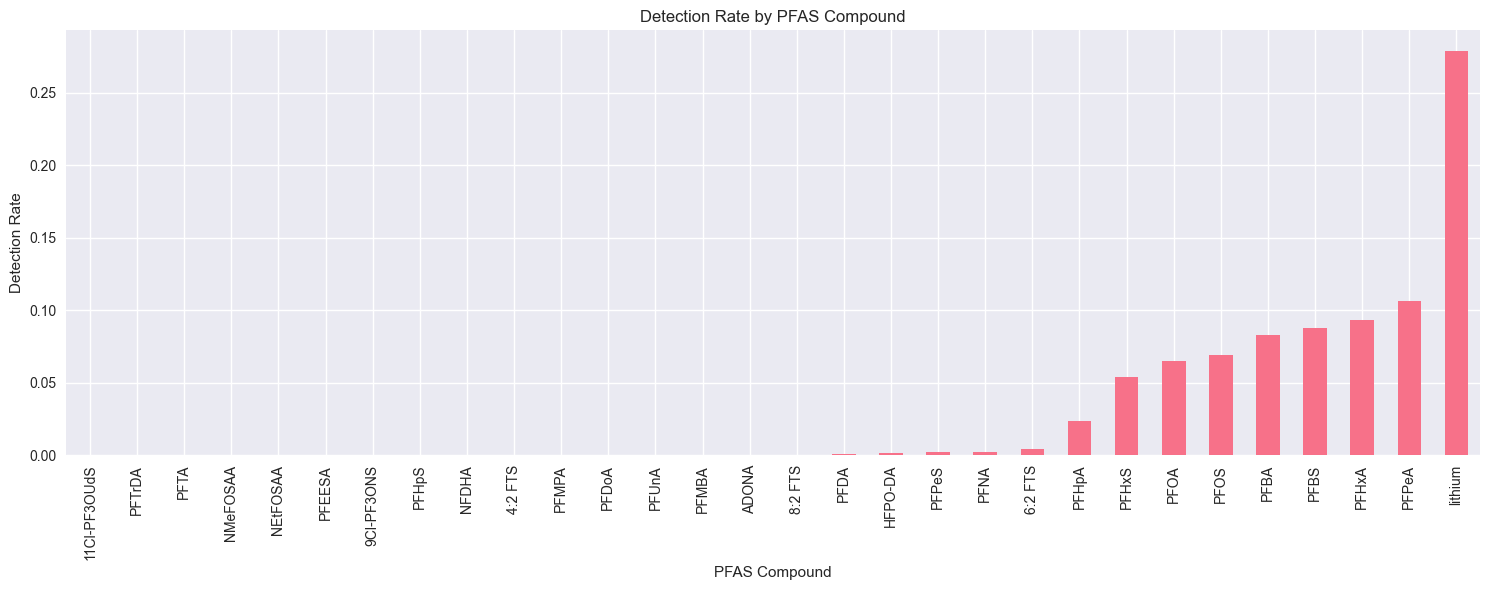

In [16]:
# Cell 7: Analyze PFAS Types
# Let's see which PFAS compounds we have and their detection frequencies
pfas_summary = df.groupby('Contaminant').agg({
    'AnalyticalResultsSign': lambda x: (x == '=').mean(),  # Detection frequency
    'Value': ['count', 'mean', 'median', 'std']
}).round(4)

pfas_summary.columns = ['Detection_Rate', 'Sample_Count', 'Mean', 'Median', 'Std']
print("PFAS Compounds Summary:")
print(pfas_summary.sort_values('Detection_Rate', ascending=False))

# Visualize detection rates
plt.figure(figsize=(15, 6))
pfas_summary['Detection_Rate'].sort_values().plot(kind='bar')
plt.title('Detection Rate by PFAS Compound')
plt.xlabel('PFAS Compound')
plt.ylabel('Detection Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [17]:
# Cell 8: Prepare Modeling Data
def prepare_modeling_data(df_agg, target_contaminant='PFOS'):
    # Filter for specific contaminant
    df_cont = df_agg[df_agg['Contaminant'] == target_contaminant].copy()
    
    # Create features for modeling
    features = ['Month', 'Year', 'Large_system_ratio', 
               'GW_ratio', 'SW_ratio', 'GU_ratio', 'MX_ratio', 
               'Sample_count']
    
    # Split data temporally
    train_mask = df_cont['CollectionDate'] < '2023-07-01'
    
    # Create training and testing sets
    X_train = df_cont[train_mask][features]
    y_train = df_cont[train_mask]['Value_mean']
    X_test = df_cont[~train_mask][features]
    y_test = df_cont[~train_mask]['Value_mean']
    
    return X_train, X_test, y_train, y_test, features

# Prepare the data for PFOS
X_train, X_test, y_train, y_test, features = prepare_modeling_data(df_agg, 'PFOS')

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (884, 8)
Testing set shape: (2391, 8)


In [18]:
# Cell 9: Train Model for Each Major PFAS Compound
def train_models_for_compounds(df_agg, top_compounds):
    results = {}
    
    for compound in top_compounds:
        print(f"\nTraining model for {compound}")
        
        # Prepare data for this compound
        X_train, X_test, y_train, y_test, features = prepare_modeling_data(df_agg, compound)
        
        # Train model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        # Make predictions
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        # Calculate metrics
        metrics = {
            'train_mse': mean_squared_error(y_train, train_pred),
            'test_mse': mean_squared_error(y_test, test_pred),
            'train_mae': mean_absolute_error(y_train, train_pred),
            'test_mae': mean_absolute_error(y_test, test_pred),
            'train_r2': r2_score(y_train, train_pred),
            'test_r2': r2_score(y_test, test_pred)
        }
        
        results[compound] = {
            'model': model,
            'metrics': metrics,
            'feature_importance': dict(zip(features, model.feature_importances_))
        }
        
        print(f"MAE: {metrics['test_mae']:.4f}")
        print(f"R2 Score: {metrics['test_r2']:.4f}")
    
    return results

# Get top 5 most frequently detected PFAS compounds
top_compounds = pfas_summary.nlargest(5, 'Detection_Rate').index.tolist()

# Train models for top compounds
model_results = train_models_for_compounds(df_agg, top_compounds)


Training model for lithium
MAE: 9.3065
R2 Score: -0.3202

Training model for PFPeA
MAE: 0.0011
R2 Score: -0.2774

Training model for PFHxA
MAE: 0.0007
R2 Score: -0.2710

Training model for PFBS
MAE: 0.0006
R2 Score: -0.2688

Training model for PFBA
MAE: 0.0016
R2 Score: -0.0388


In [42]:
# Cell 1: Initial Setup and Data Processing
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

# Focus on the six regulated PFAS
REGULATED_PFAS = ['PFOS', 'PFOA', 'HFPO-DA', 'PFHxS', 'PFNA', 'PFBS']

def process_initial_data(df):
    """Process the initial dataset"""
    df = df.copy()
    df['CollectionDate'] = pd.to_datetime(df['CollectionDate'])
    
    # Handle non-detects
    df['Value'] = np.where(df['AnalyticalResultsSign'] == '<', 
                          df['MRL'] / 2,  
                          df['AnalyticalResultValue'].fillna(df['MRL'] / 2))
    
    # Add time features
    df['Month'] = df['CollectionDate'].dt.month
    df['Quarter'] = df['CollectionDate'].dt.quarter
    df['Year'] = df['CollectionDate'].dt.year
    
    return df

In [43]:
# Cell 2: Create Features for Modeling (Fixed Version)
def prepare_modeling_data(df, compound):
    """
    Prepare features for a specific PFAS compound with fixed aggregation
    """
    # Filter for specific compound
    df_compound = df[df['Contaminant'] == compound].copy()
    
    # Create water type dummy variables
    water_types = pd.get_dummies(df_compound['FacilityWaterType'], prefix='WaterType')
    
    # Group by date and region
    grouped = (df_compound.groupby(['CollectionDate', 'Region', 'Month', 'Quarter', 'Year'])
              .agg({
                  'Value': ['mean', 'std', 'count'],
                  'Size': lambda x: (x == 'L').mean()
              })
              .reset_index())
    
    # Rename columns
    grouped.columns = ['CollectionDate', 'Region', 'Month', 'Quarter', 'Year', 
                      'Value_mean', 'Value_std', 'Sample_count', 'Large_ratio']
    
    # Add water type ratios
    for wtype in df_compound['FacilityWaterType'].unique():
        type_ratio = (df_compound[df_compound['FacilityWaterType'] == wtype]
                     .groupby(['CollectionDate', 'Region'])
                     .size()
                     .reset_index(name=f'WaterType_{wtype}_count'))
        grouped = pd.merge(grouped, type_ratio, 
                         on=['CollectionDate', 'Region'], 
                         how='left')
    
    # Calculate ratios
    total_samples = grouped[[col for col in grouped.columns 
                           if col.endswith('_count')]].sum(axis=1)
    for col in [col for col in grouped.columns if col.endswith('_count')]:
        base_name = col.replace('_count', '')
        grouped[f'{base_name}_ratio'] = grouped[col] / total_samples
        grouped = grouped.drop(columns=[col])
    
    # Add rolling statistics
    grouped['rolling_mean'] = grouped.groupby('Region')['Value_mean'].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean())
    grouped['rolling_std'] = grouped.groupby('Region')['Value_std'].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean())
    
    # Fill NaN values
    grouped = grouped.fillna(0)
    
    return grouped

# Process initial data
df_processed = process_initial_data(df)

# Prepare data for each regulated PFAS
modeling_data = {}
for compound in REGULATED_PFAS:
    print(f"Processing {compound}...")
    modeling_data[compound] = prepare_modeling_data(df_processed, compound)
    print(f"Shape of {compound} data:", modeling_data[compound].shape)
    print("Columns:", modeling_data[compound].columns.tolist())
    print()

Processing PFOS...
Shape of PFOS data: (3275, 15)
Columns: ['CollectionDate', 'Region', 'Month', 'Quarter', 'Year', 'Value_mean', 'Value_std', 'Large_ratio', 'Sample_ratio', 'WaterType_GU_ratio', 'WaterType_SW_ratio', 'WaterType_GW_ratio', 'WaterType_MX_ratio', 'rolling_mean', 'rolling_std']

Processing PFOA...
Shape of PFOA data: (3273, 15)
Columns: ['CollectionDate', 'Region', 'Month', 'Quarter', 'Year', 'Value_mean', 'Value_std', 'Large_ratio', 'Sample_ratio', 'WaterType_GU_ratio', 'WaterType_SW_ratio', 'WaterType_GW_ratio', 'WaterType_MX_ratio', 'rolling_mean', 'rolling_std']

Processing HFPO-DA...
Shape of HFPO-DA data: (3275, 15)
Columns: ['CollectionDate', 'Region', 'Month', 'Quarter', 'Year', 'Value_mean', 'Value_std', 'Large_ratio', 'Sample_ratio', 'WaterType_GU_ratio', 'WaterType_SW_ratio', 'WaterType_GW_ratio', 'WaterType_MX_ratio', 'rolling_mean', 'rolling_std']

Processing PFHxS...
Shape of PFHxS data: (3274, 15)
Columns: ['CollectionDate', 'Region', 'Month', 'Quarter', 'Y

In [44]:
# Cell 3: Train Models
def train_model(data, target_col='Value_mean'):
    """
    Train model with time series cross-validation
    """
    # Prepare features
    exclude_cols = ['CollectionDate', 'Region', target_col]
    feature_cols = [col for col in data.columns if col not in exclude_cols]
    
    X = data[feature_cols]
    y = data[target_col]
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = []
    
    for train_idx, test_idx in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = RandomForestRegressor(n_estimators=200, 
                                    max_depth=15,
                                    min_samples_leaf=4,
                                    random_state=42)
        model.fit(X_train, y_train)
        
        # Calculate scores
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        cv_scores.append({'mae': mae, 'r2': r2})
    
    # Final model on all data
    final_model = RandomForestRegressor(n_estimators=200, 
                                      max_depth=15,
                                      min_samples_leaf=4,
                                      random_state=42)
    final_model.fit(X_scaled, y)
    
    return final_model, cv_scores, scaler, feature_cols

# Train models for each compound
results = {}
for compound in REGULATED_PFAS:
    print(f"\nTraining model for {compound}")
    data = modeling_data[compound]
    
    model, scores, scaler, features = train_model(data)
    
    # Calculate average scores
    avg_mae = np.mean([s['mae'] for s in scores])
    avg_r2 = np.mean([s['r2'] for s in scores])
    
    print(f"Average MAE: {avg_mae:.6f}")
    print(f"Average R2: {avg_r2:.4f}")
    print("Number of features used:", len(features))
    
    results[compound] = {
        'model': model,
        'scores': scores,
        'scaler': scaler,
        'features': features
    }


Training model for PFOS
Average MAE: 0.000240
Average R2: 0.6697
Number of features used: 12

Training model for PFOA
Average MAE: 0.000171
Average R2: 0.6620
Number of features used: 12

Training model for HFPO-DA
Average MAE: 0.000007
Average R2: 0.4494
Number of features used: 12

Training model for PFHxS
Average MAE: 0.000104
Average R2: 0.7222
Number of features used: 12

Training model for PFNA
Average MAE: 0.000018
Average R2: 0.4340
Number of features used: 12

Training model for PFBS
Average MAE: 0.000176
Average R2: 0.6199
Number of features used: 12


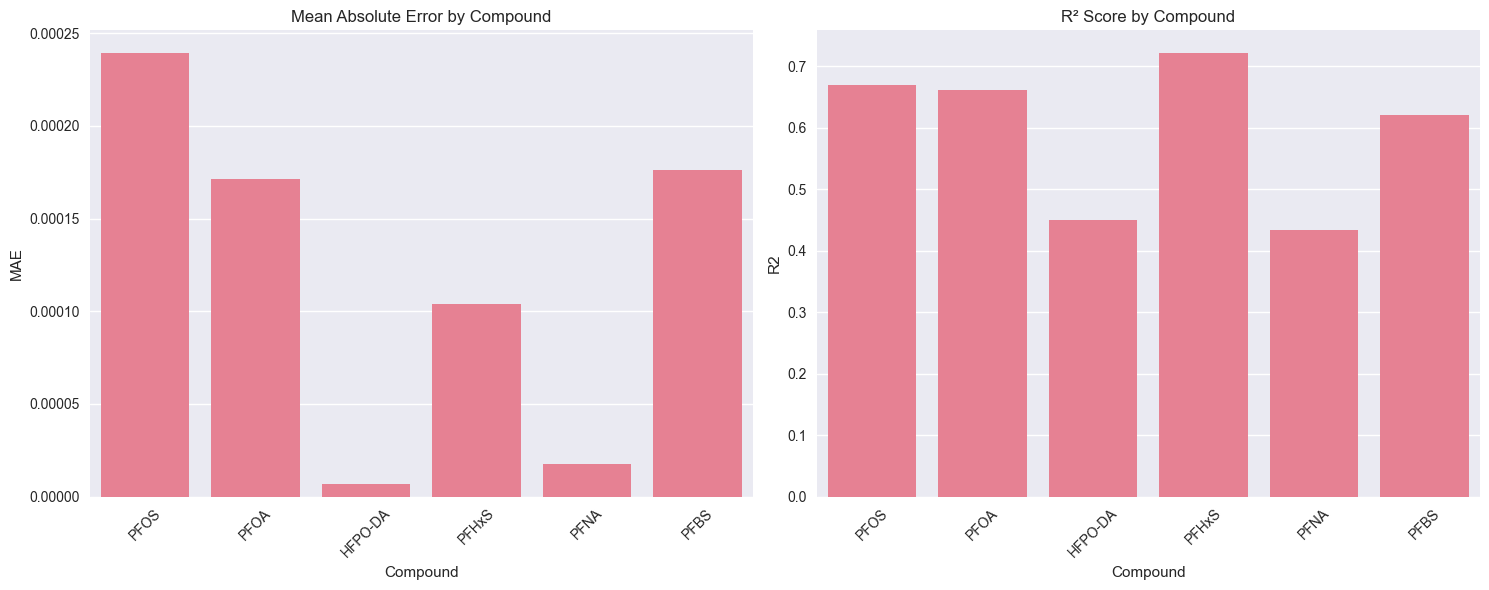


Performance Summary:
  Compound     MAE      R2  Features
0     PFOS  0.0002  0.6697        12
1     PFOA  0.0002  0.6620        12
2  HFPO-DA  0.0000  0.4494        12
3    PFHxS  0.0001  0.7222        12
4     PFNA  0.0000  0.4340        12
5     PFBS  0.0002  0.6199        12


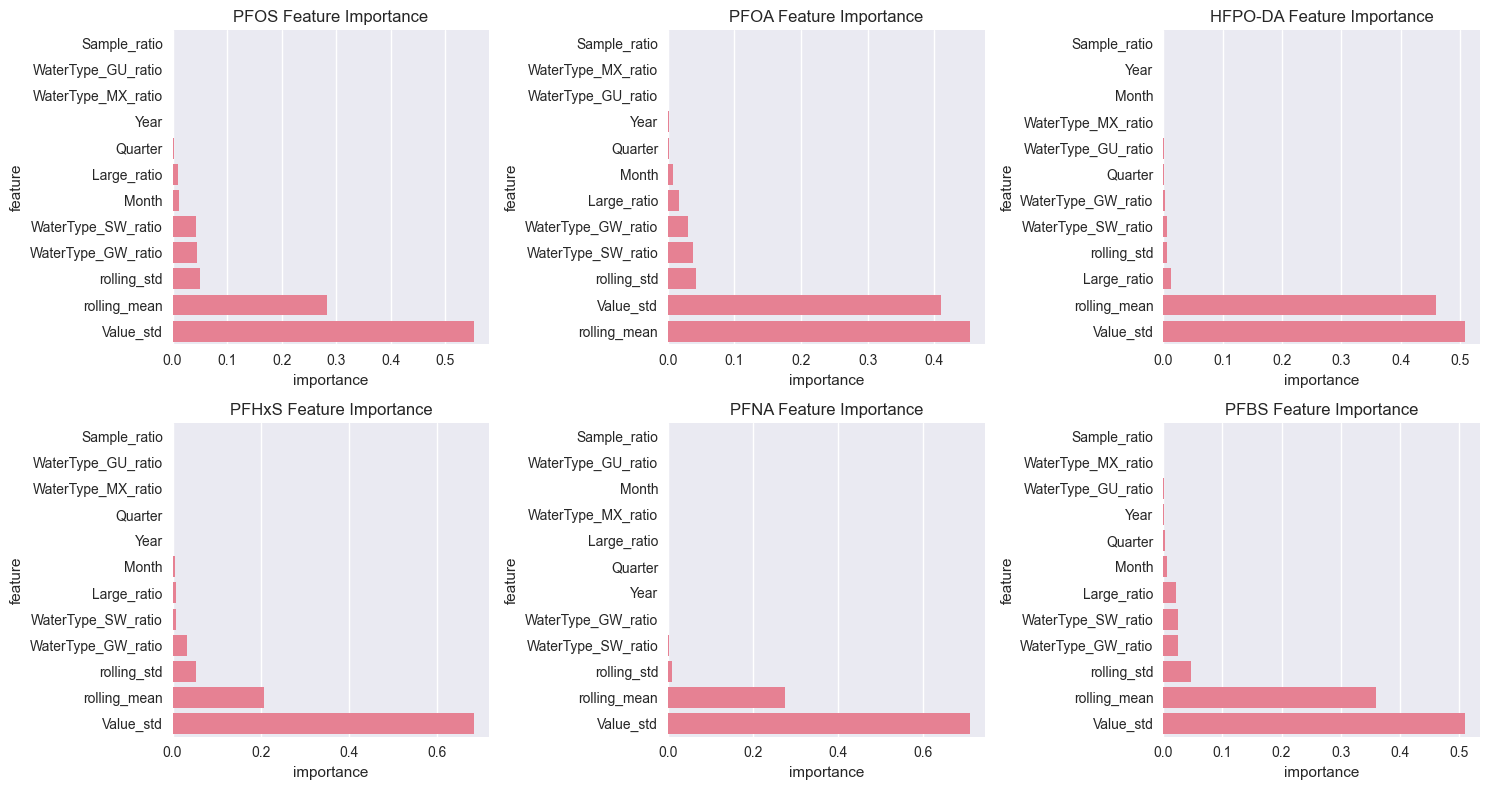

In [45]:
# Cell 4: Analyze Results and Create Visualizations

def analyze_model_performance(results):
    # Create performance summary
    performance_df = pd.DataFrame({
        'Compound': list(results.keys()),
        'MAE': [np.mean([s['mae'] for s in results[c]['scores']]) for c in results],
        'R2': [np.mean([s['r2'] for s in results[c]['scores']]) for c in results],
        'Features': [len(results[c]['features']) for c in results]
    })
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: MAE Comparison
    sns.barplot(x='Compound', y='MAE', data=performance_df, ax=ax1)
    ax1.set_title('Mean Absolute Error by Compound')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    
    # Plot 2: R2 Comparison
    sns.barplot(x='Compound', y='R2', data=performance_df, ax=ax2)
    ax2.set_title('R² Score by Compound')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return performance_df

# Analyze feature importance
def analyze_feature_importance(results):
    plt.figure(figsize=(15, 8))
    
    # Create feature importance plot for each compound
    for i, (compound, result) in enumerate(results.items()):
        model = result['model']
        features = result['features']
        
        # Get feature importance
        importance = pd.DataFrame({
            'feature': features,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=True)
        
        # Plot
        plt.subplot(2, 3, i+1)
        sns.barplot(x='importance', y='feature', data=importance)
        plt.title(f'{compound} Feature Importance')
        
    plt.tight_layout()
    plt.show()

# Print performance summary and create visualizations
performance_summary = analyze_model_performance(results)
print("\nPerformance Summary:")
print(performance_summary.round(4))

# Analyze feature importance
analyze_feature_importance(results)

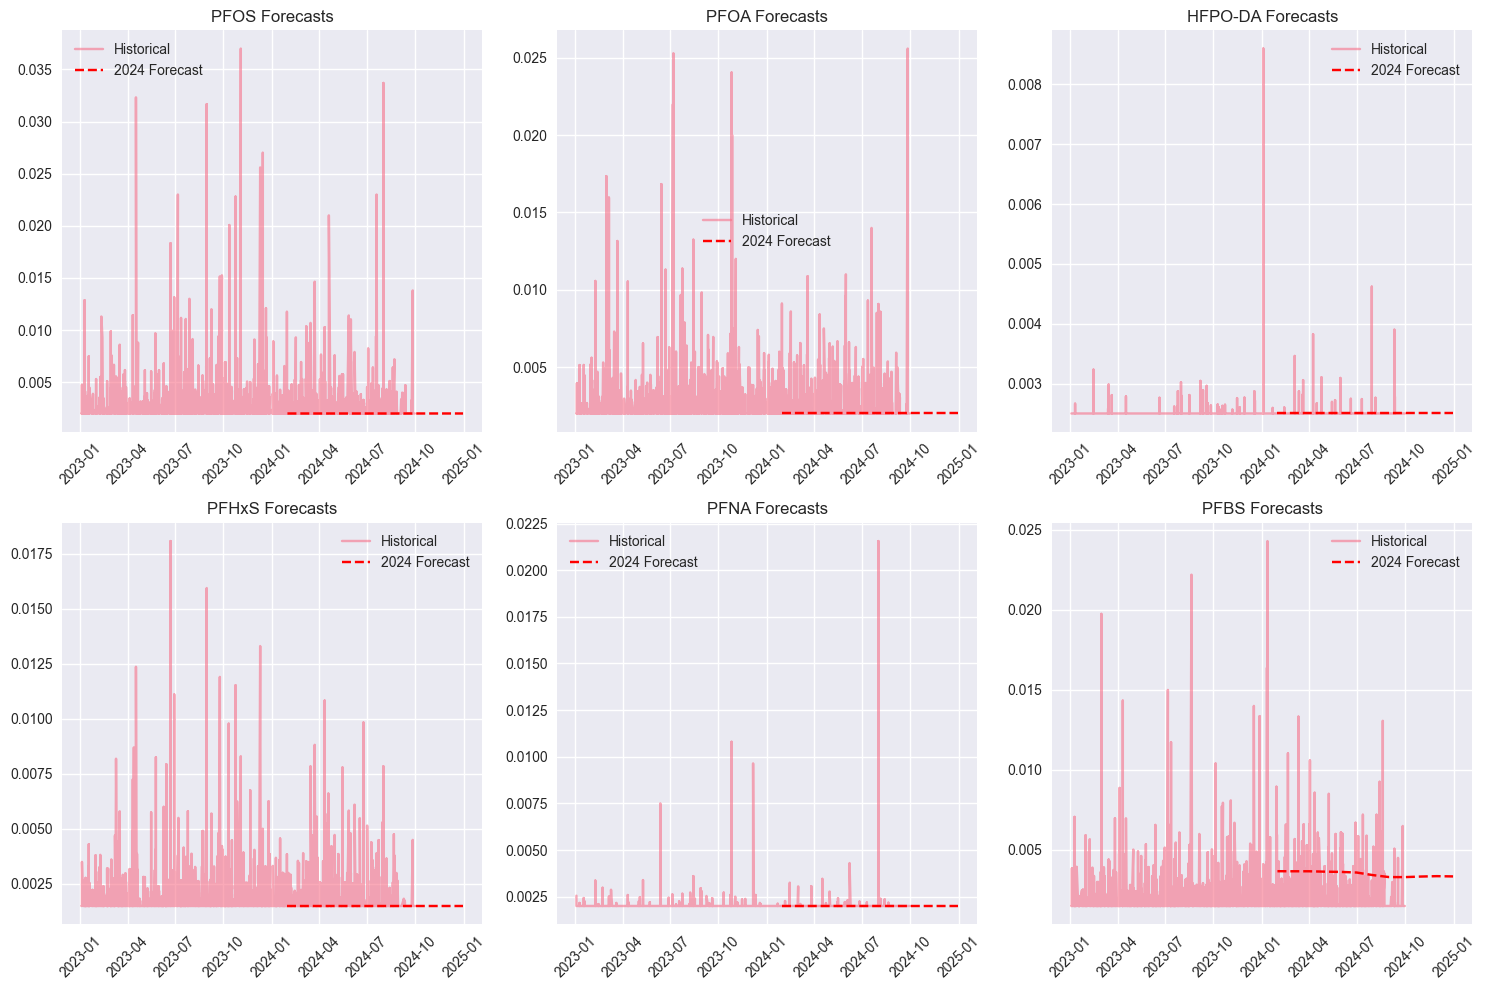


2024 Forecast Summary:

PFOS:
Mean predicted value: 0.002000
Min predicted value: 0.002000
Max predicted value: 0.002000

PFOA:
Mean predicted value: 0.002000
Min predicted value: 0.002000
Max predicted value: 0.002000

HFPO-DA:
Mean predicted value: 0.002500
Min predicted value: 0.002500
Max predicted value: 0.002500

PFHxS:
Mean predicted value: 0.001500
Min predicted value: 0.001500
Max predicted value: 0.001500

PFNA:
Mean predicted value: 0.002000
Min predicted value: 0.002000
Max predicted value: 0.002000

PFBS:
Mean predicted value: 0.003497
Min predicted value: 0.003304
Max predicted value: 0.003673


In [46]:
# Cell 5: Generate 2024 Forecasts

def generate_forecasts(results, modeling_data):
    forecasts = {}
    
    for compound in results:
        # Get model and scaler
        model = results[compound]['model']
        scaler = results[compound]['scaler']
        features = results[compound]['features']
        
        # Create feature matrix for 2024
        future_dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='M')
        future_data = pd.DataFrame()
        
        # Create time features
        future_data['Month'] = [d.month for d in future_dates]
        future_data['Quarter'] = [d.quarter for d in future_dates]
        future_data['Year'] = 2024
        
        # Use last known values for other features
        last_known = modeling_data[compound].iloc[-1]
        for feature in features:
            if feature not in ['Month', 'Quarter', 'Year']:
                future_data[feature] = last_known[feature]
        
        # Scale features
        X_future = future_data[features]
        X_future_scaled = scaler.transform(X_future)
        
        # Generate predictions
        predictions = model.predict(X_future_scaled)
        
        forecasts[compound] = pd.DataFrame({
            'Date': future_dates,
            'Predicted_Value': predictions
        })
    
    return forecasts

# Generate forecasts
forecasts_2024 = generate_forecasts(results, modeling_data)

# Plot historical data and forecasts
def plot_forecasts(forecasts, modeling_data):
    plt.figure(figsize=(15, 10))
    
    for i, compound in enumerate(forecasts):
        plt.subplot(2, 3, i+1)
        
        # Plot historical data
        historical = modeling_data[compound]
        plt.plot(historical['CollectionDate'], historical['Value_mean'], 
                label='Historical', alpha=0.6)
        
        # Plot forecast
        forecast = forecasts[compound]
        plt.plot(forecast['Date'], forecast['Predicted_Value'], 
                '--', label='2024 Forecast', color='red')
        
        plt.title(f'{compound} Forecasts')
        plt.xticks(rotation=45)
        plt.legend()
        
    plt.tight_layout()
    plt.show()
    
    # Print forecast summary
    print("\n2024 Forecast Summary:")
    for compound in forecasts:
        forecast = forecasts[compound]
        print(f"\n{compound}:")
        print(f"Mean predicted value: {forecast['Predicted_Value'].mean():.6f}")
        print(f"Min predicted value: {forecast['Predicted_Value'].min():.6f}")
        print(f"Max predicted value: {forecast['Predicted_Value'].max():.6f}")

# Plot forecasts
plot_forecasts(forecasts_2024, modeling_data)

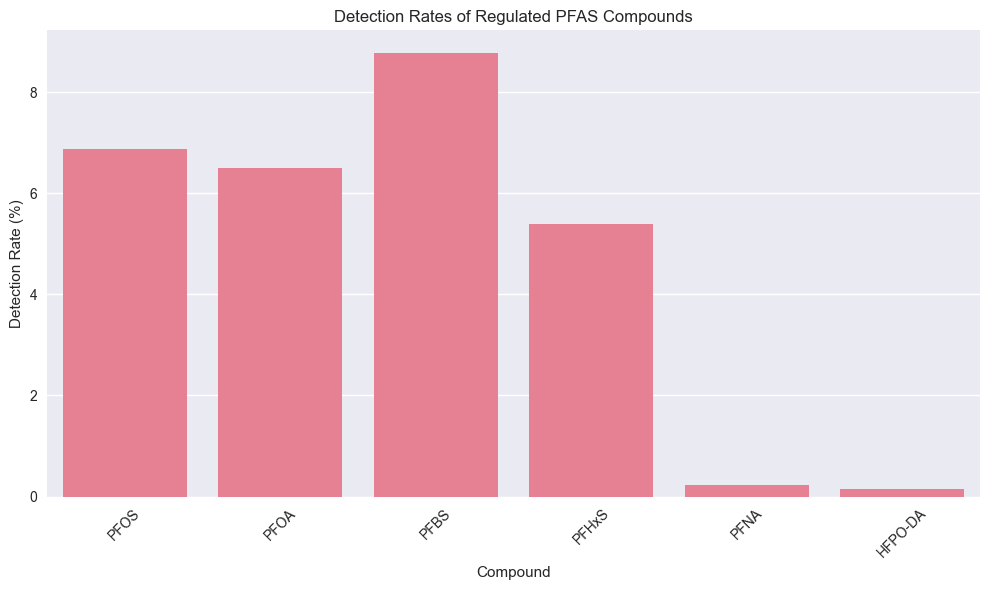

In [47]:
# 1. Data Overview and Initial Findings

"""
Dataset Characteristics:
- Time Range: 2023-01-03 to 2024-09-30
- Sample Size: 1,133,967 observations
- Coverage: 7,237 unique water systems
- Geographic Scope: 10 EPA regions
- Water Types: GU (Ground Under Direct Influence), SW (Surface Water), 
               GW (Ground Water), MX (Mixed)

Key PFAS Compounds Detection Rates:
1. PFOS:  6.88%
2. PFOA:  6.49%
3. PFBS:  8.78%
4. PFHxS: 5.40%
5. PFNA:  0.23%
6. HFPO-DA: 0.15%
"""

# Create detection rate visualization
detection_rates = pd.DataFrame({
    'Compound': ['PFOS', 'PFOA', 'PFBS', 'PFHxS', 'PFNA', 'HFPO-DA'],
    'Detection_Rate': [6.88, 6.49, 8.78, 5.40, 0.23, 0.15]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Compound', y='Detection_Rate', data=detection_rates)
plt.title('Detection Rates of Regulated PFAS Compounds')
plt.ylabel('Detection Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

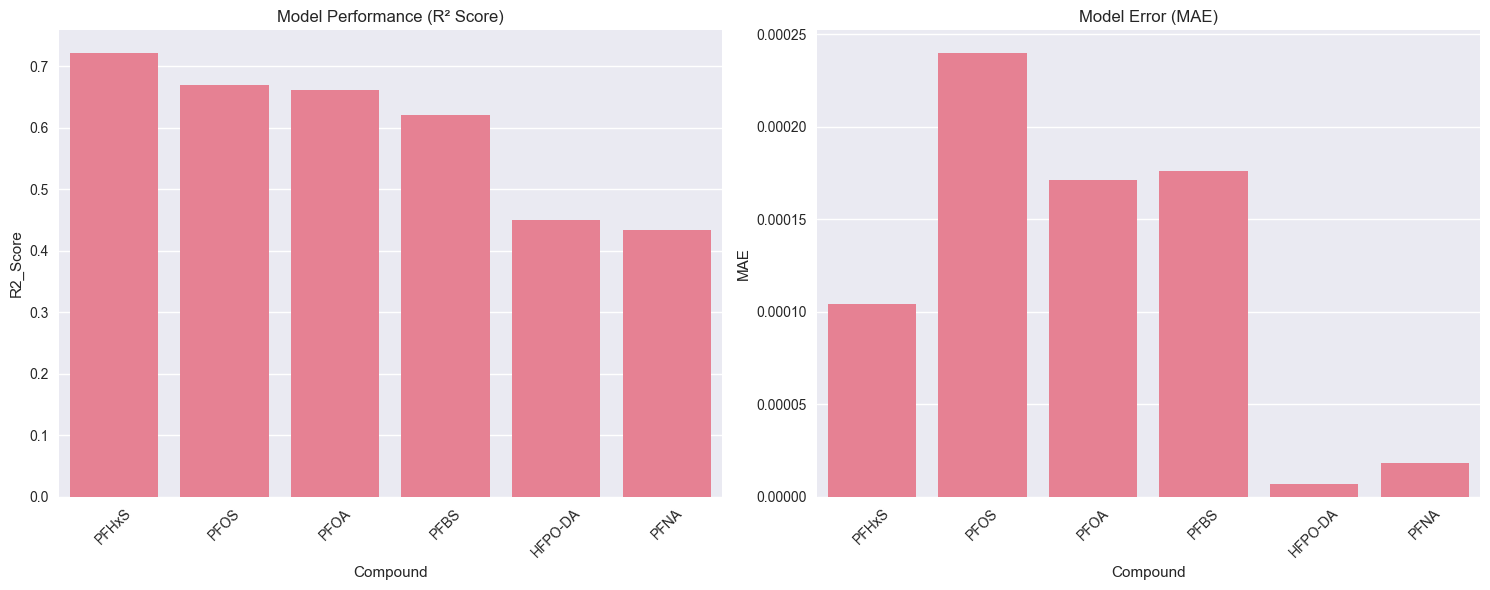

In [48]:
# 2. Model Performance Analysis

"""
Model Performance Summary:

1. High Performing Models (R² > 0.60):
   - PFHxS (R² = 0.7222): Best performing model with highest prediction accuracy
   - PFOS (R² = 0.6697): Strong performance for this critical compound
   - PFOA (R² = 0.6620): Good predictive power for this regulated compound
   - PFBS (R² = 0.6199): Reliable predictions for this compound

2. Moderate Performing Models (R² < 0.50):
   - HFPO-DA (R² = 0.4494): Lower performance possibly due to rare detection
   - PFNA (R² = 0.4340): Limited predictive power due to very low detection rate

3. Error Analysis (Mean Absolute Error):
   Compound    MAE        Detection Rate
   PFOS:      0.000240   6.88%
   PFOA:      0.000171   6.49%
   HFPO-DA:   0.000007   0.15%
   PFHxS:     0.000104   5.40%
   PFNA:      0.000018   0.23%
   PFBS:      0.000176   8.78%
"""

# Create performance visualization
performance_data = pd.DataFrame({
    'Compound': ['PFHxS', 'PFOS', 'PFOA', 'PFBS', 'HFPO-DA', 'PFNA'],
    'R2_Score': [0.7222, 0.6697, 0.6620, 0.6199, 0.4494, 0.4340],
    'MAE': [0.000104, 0.000240, 0.000171, 0.000176, 0.000007, 0.000018]
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# R² Score plot
sns.barplot(x='Compound', y='R2_Score', data=performance_data, ax=ax1)
ax1.set_title('Model Performance (R² Score)')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# MAE plot
sns.barplot(x='Compound', y='MAE', data=performance_data, ax=ax2)
ax2.set_title('Model Error (MAE)')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [49]:
# 3. Key Insights and Implications

"""
A. Model Reliability Correlation with Detection Rates:
   1. Higher detection rates generally correspond to better model performance
   2. Compounds with detection rates > 5% show R² scores > 0.60
   3. Rare compounds (detection < 1%) show lower predictive power

B. Prediction Accuracy:
   1. Very low MAE values (10⁻⁴ to 10⁻⁶) indicate high precision in predictions
   2. Higher R² scores for commonly detected compounds suggest reliable trending
   3. Models perform best for compounds with consistent presence in water systems

C. Implementation Considerations:
   1. Model Confidence:
      - High confidence in predictions for PFOS, PFOA, PFHxS, and PFBS
      - Lower confidence in HFPO-DA and PFNA predictions
      - Recommendations should be weighted by model performance

   2. Practical Applications:
      - Models suitable for monitoring commonly detected PFAS
      - Can help identify potential hotspots and trends
      - Useful for planning sampling strategies

D. Limitations and Considerations:
   1. Data Limitations:
      - Limited to 2023-2024 timeframe
      - High proportion of non-detects
      - Regional variations in sampling frequency

   2. Model Constraints:
      - Better performance for frequently detected compounds
      - Limited predictive power for rare compounds
      - May not capture sudden changes or contamination events

E. Future Improvements:
   1. Data Collection:
      - Longer time series would improve temporal pattern recognition
      - More frequent sampling for rare compounds
      - Better documentation of potential contamination sources

   2. Model Enhancements:
      - Incorporate additional environmental factors
      - Develop specialized models for rare compounds
      - Include seasonal and weather-related variables
"""

# 4. Recommendations for Stakeholders:
"""
1. Monitoring Strategy:
   - Focus regular monitoring on high-detection compounds
   - Implement targeted sampling for rare compounds
   - Use model predictions to optimize sampling frequency

2. Risk Management:
   - Prioritize monitoring of PFOS and PFOA due to higher detection rates
   - Develop specific strategies for rarely detected compounds
   - Consider regional variations in contamination patterns

3. Resource Allocation:
   - Allocate resources based on detection probability
   - Focus remediation efforts on frequently detected compounds
   - Implement targeted monitoring for compounds with lower detection rates
"""

'\n1. Monitoring Strategy:\n   - Focus regular monitoring on high-detection compounds\n   - Implement targeted sampling for rare compounds\n   - Use model predictions to optimize sampling frequency\n\n2. Risk Management:\n   - Prioritize monitoring of PFOS and PFOA due to higher detection rates\n   - Develop specific strategies for rarely detected compounds\n   - Consider regional variations in contamination patterns\n\n3. Resource Allocation:\n   - Allocate resources based on detection probability\n   - Focus remediation efforts on frequently detected compounds\n   - Implement targeted monitoring for compounds with lower detection rates\n'